In [49]:
import torchOptics.optics as tt
import warnings
import torch.nn as nn
import torchOptics.metrics as tm
import torch.nn.functional as F
import torch.optim
import torch
from torch.utils.data import Dataset, DataLoader
import os
import glob
import numpy as np
import matplotlib.pyplot as plt
import pickle
import torchvision
import datetime
import tqdm
import time
import HHS.model


warnings.filterwarnings('ignore')


class SignFunction(torch.autograd.Function):
    @staticmethod
    def forward(ctx, input):
        ctx.save_for_backward(input)
        t = torch.Tensor([0.5]).cuda()  # threshold
        output = (input > t).float() * 1
        return output

    @staticmethod
    def backward(ctx, grad_output):
        input, = ctx.saved_tensors
        grad_input = grad_output * torch.ones_like(input)  # Replace with your custom gradient computation
        return grad_input


class Dataset512(Dataset):
    def __init__(self, target_dir, meta, transform=None, isTrain=True):
        self.target_dir = target_dir
        self.transform = transform
        self.meta = meta
        self.isTrain = isTrain
        self.target_list = sorted(glob.glob(target_dir+'*.png'))
        self.center_crop = torchvision.transforms.CenterCrop(512)
        self.random_crop = torchvision.transforms.RandomCrop((512, 512))

    def __len__(self):
        return len(self.target_list)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        target = tt.imread(self.target_list[idx], meta=meta, gray=True)
        if self.isTrain:
            target = self.random_crop(target)
        else:
            target = self.center_crop(target)
        return target


def initialize_weights(m):
    if isinstance(m, nn.Conv2d):
        nn.init.kaiming_uniform_(m.weight.data, nonlinearity='relu')
        if m.bias is not None:
            nn.init.constant_(m.bias.data, 0)
    elif isinstance(m, nn.BatchNorm2d):
        nn.init.constant_(m.weight.data, 1)
        nn.init.constant_(m.bias.data, 0)
    elif isinstance(m, nn.Linear):
        nn.init.kaiming_uniform_(m.weight.data)
        nn.init.constant_(m.bias.data, 0)

# load data
batch_size = 1
target_dir = 'dataset/DIV2K/DIV2K_train_HR/'
valid_dir = 'dataset/DIV2K/DIV2K_valid_HR/'
# sim_dir = 'binary_dataset/simulated/'
meta = {'wl' : (515e-9), 'dx':(6.3e-6, 6.3e-6)}
train_dataset = Dataset512(target_dir=target_dir, meta=meta, isTrain=True)
valid_dataset = Dataset512(target_dir=valid_dir, meta=meta, isTrain=False)

trainloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
validloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)


def initialize_weights(m):
    if isinstance(m, nn.Conv2d):
        nn.init.kaiming_uniform_(m.weight.data, nonlinearity='relu')
        if m.bias is not None:
            nn.init.constant_(m.bias.data, 0)
    elif isinstance(m, nn.BatchNorm2d):
        nn.init.constant_(m.weight.data, 1)
        nn.init.constant_(m.bias.data, 0)
    elif isinstance(m, nn.Linear):
        nn.init.kaiming_uniform_(m.weight.data)
        nn.init.constant_(m.bias.data, 0)


def train(model, num_hologram=10, custom_name='fcn', epochs=100, lr=1e-4, z=2e-3):
    date = datetime.datetime.now() - datetime.timedelta(hours=15)
    mean_psnr_list = []
    mean_mse_list = []
    max_epoch = 0
    max_psnr = 0
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    sign_function = SignFunction.apply
    # path = 'models/'
    model_name = f'{date}_{custom_name}_{num_hologram}_{z}'
    # make result folder
    result_folder = 'result/'+model_name
    os.mkdir(result_folder)
    model_path = os.path.join(result_folder, model_name)
    psnr_result_path = os.path.join(result_folder, 'meanPSNR.npy')
    mse_result_path = os.path.join(result_folder, 'meanMSE.npy')
    result = {'model_path': model_path, 'psnr_result_path': psnr_result_path,
          'mse_result_path': mse_result_path, 'z': z,
          'num_hologram': num_hologram, 'lr': lr, 'epochs': epochs}
    # save result dict
    with open(os.path.join(result_folder, 'result_dict.pickle'), 'wb') as fw:
        pickle.dump(result, fw)
    for epoch in range(epochs):
        pbar = tqdm.tqdm(trainloader)
        model.train()
        for target in pbar:
            out = model(target)
            binary = sign_function(out)
            sim = tt.simulate(binary, z).abs()**2
            result = torch.mean(sim, dim=1, keepdim=True)
            loss = tt.relativeLoss(result, target, F.mse_loss)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        model.eval()
        with torch.no_grad():
            psnrList = []
            mseList = []
            for valid in validloader:
                out = model(valid)
                binary = sign_function(out)
                sim = tt.simulate(binary, z).abs()**2
                result = torch.mean(sim, dim=1, keepdim=True)
                psnr = tt.relativeLoss(result, valid, tm.get_PSNR)
                psnrList.append(psnr)
                mse = tt.relativeLoss(result, valid, F.mse_loss).detach().cpu().numpy()
                mseList.append(mse)
            mean_psnr = sum(psnrList)/len(psnrList)
            mean_mse = sum(mseList)/len(mseList)
            mean_psnr_list.append(mean_psnr)
            mean_mse_list.append(mean_mse)
            # save psnr and mse
            np.save(psnr_result_path, mean_psnr_list)
            np.save(mse_result_path, mean_mse_list)
            plt.plot(np.arange(len(mean_psnr_list)), mean_psnr_list,
                     label=f'max psnr: {max(mean_psnr_list)}')
            plt.title(model_name+'_psnr')
            plt.legend()
            plt.savefig(os.path.join(result_folder, 'meanPSNR.png'))
            plt.clf()
            plt.plot(np.arange(len(mean_mse_list)), mean_mse_list,
                     label=f'max psnr: {min(mean_mse_list)}')
            plt.title(model_name+'_mse')
            plt.legend()
            plt.savefig(os.path.join(result_folder, 'meanMSE.png'))
            plt.clf()
            print(f'mean PSNR : {mean_psnr} {epoch}/{epochs}')
            print(f'mean MSE : {mean_mse} {epoch}/{epochs}')

        if mean_psnr > max_psnr:
            max_psnr = mean_psnr
            max_epoch = epoch
            torch.save(model.state_dict(), model_path)
        print(f'max_psnr: {max_psnr}, epoch: {max_epoch}')


def binary_sim(out, z=2e-3):
    binary = SignFunction.apply(out)
    sim = tt.simulate(binary, z).abs()**2
    res = torch.mean(sim, dim=1, keepdim=True)
    return binary, res


def valid(model):
    with torch.no_grad():
        psnr_list = []
        for target in validloader:
            out = model(target)
            binary, res = binary_sim(out)
            psnr = tt.relativeLoss(res, target, tm.get_PSNR)
            psnr_list.append(psnr)
    print(sum(psnr_list)/len(psnr_list))


def check_order(bmodel, classifier, target):
    if len(target.shape) == 3:
        target = target.unsqueeze(0)
    result = []
    with torch.no_grad():
        out = bmodel(target)
        binary, res = binary_sim(out)
        for i in range(10):
            binary_input = binary[0][i].unsqueeze(0).unsqueeze(0)
            prop_order = classifier(binary_input)
            result.append(torch.argmax(prop_order))
    print(result)


def check_order_without_model(binary, classifier):
    with torch.no_grad():
        result = []
        for i in range(10):
            binary_input = binary[0][i].unsqueeze(0).unsqueeze(0)
            prop_order = classifier(binary_input)
            result.append(torch.argmax(prop_order))
    print(result)


class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.fc = nn.Linear(64 * 64 * 64, 10)  # 최종 분류를 위한 FC 레이어

    def forward(self, x):
        x = self.pool1(torch.relu(self.conv1(x)))
        x = self.pool2(torch.relu(self.conv2(x)))
        x = self.pool3(torch.relu(self.conv3(x)))
        x = x.view(-1, 64 * 64 * 64)  # flatten
        x = self.fc(x)
        return x


def rgb_binary_sim(out, z):
    meta = {'wl' : (638e-9, 515e-9, 450e-9), 'dx':(6.3e-6, 6.3e-6)}
    rmeta = {'wl': (638e-9), 'dx': (6.3e-6, 6.3e-6)}
    gmeta = {'wl': (515e-9), 'dx': (6.3e-6, 6.3e-6)}
    bmeta = {'wl': (450e-9), 'dx': (6.3e-6, 6.3e-6)}
    sign = SignFunction.apply
    binary = sign(out)
    channel = out.shape[1]
    rchannel = int(channel/3)
    gchannel = int(channel*2/3)
    red = binary[:, :rchannel, :, :]
    green = binary[:, rchannel:gchannel, :, :]
    blue = binary[:, gchannel:, :, :]
    red = tt.Tensor(red, meta=rmeta)
    green = tt.Tensor(green, meta=gmeta)
    blue = tt.Tensor(blue, meta=bmeta)
    rsim = tt.simulate(red, z).abs()**2
    gsim = tt.simulate(green, z).abs()**2
    bsim = tt.simulate(blue, z).abs()**2
    rmean = torch.mean(rsim, dim=1, keepdim=True)
    gmean = torch.mean(gsim, dim=1, keepdim=True)
    bmean = torch.mean(bsim, dim=1, keepdim=True)
    rgb = torch.cat([rmean, gmean, bmean], dim=1)
    rgb = tt.Tensor(rgb, meta=meta)
    binary = tt.Tensor(binary, meta=meta)
    return binary, rgb

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [50]:
target = valid_dataset[0].unsqueeze(0).unsqueeze(0).cuda()
crop_64 = torchvision.transforms.CenterCrop(64)
crop_80 = torchvision.transforms.CenterCrop(80)
target = crop_80(target)
crop_target = crop_64(target)
target.shape

torch.Size([1, 1, 80, 80])

In [95]:
# import gym
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
import numpy as np
import random
from collections import deque
import math
import matplotlib.pyplot as plt

def find_index(index_1d, shape):
    index_4d = (
        index_1d // (shape[2] * shape[3] * shape[1]),  # 첫 번째 차원
        (index_1d % (shape[2] * shape[3] * shape[1])) // (shape[2] * shape[3]),  # 두 번째 차원
        (index_1d % (shape[2] * shape[3])) // shape[3],  # 세 번째 차원
        index_1d % shape[3]  # 네 번째 차원
    )
    return index_4d

EPS_SATURATION = 0.1
EPS_INIT = 0.8
EPS_DECAY = 100
LR = 0.001
BATCH_SIZE = 64
GAMMA = 0.8


# 뉴럴 네트워크 모델 만들기
class NeuralNetwork(nn.Module):

    #class에서 쓸 parameter들
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.linear_relu_stack = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.LeakyReLU(0.01),  # LeakyReLU activation
            nn.Conv2d(32, 32, kernel_size=3, stride=2, padding=1),
            nn.LeakyReLU(0.01),
            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.LeakyReLU(0.01),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.LeakyReLU(0.01),  # LeakyReLU activation
            nn.Conv2d(64, 64, kernel_size=3, stride=2, padding=1),
            nn.LeakyReLU(0.01),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.LeakyReLU(0.01),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.LeakyReLU(0.01),  # LeakyReLU activation
            nn.Conv2d(128, 128, kernel_size=3, stride=2, padding=1),
            nn.LeakyReLU(0.01),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.LeakyReLU(0.01),
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, dilation=1, output_padding=1),
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, dilation=1, output_padding=1),
            nn.ConvTranspose2d(32, 3, kernel_size=3, stride=2, padding=1, dilation=1, output_padding=1)
        )
        self.optimizer = optim.Adam(self.linear_relu_stack.parameters(), LR)
        self.number_of_steps = 0
        self.memory = deque(maxlen=2000) #메모리는 deque list (1000개 넘으면 순서대로 삭제)
    
    #pytorch에서는 forward를 정의해줘야함.
    def forward(self, x):
        output = self.linear_relu_stack(x)
        return output

    #에피소드들을 기억(memory에 append)한다
    def memorize(self, state, action, reward, next_state):
        self.memory.append([state,action,torch.FloatTensor([reward]),next_state])

    #입실론을 정해서 랜덤 행동 / 신경망 행동 둘중 하나를 정해준다.
    def decision(self, state):
        self.number_of_steps += 1
        eps_th = EPS_SATURATION + (EPS_INIT - EPS_SATURATION) * math.exp(-1 * self.number_of_steps / EPS_DECAY)
        if random.random() > eps_th:
            output = self.linear_relu_stack(state)
            return torch.nn.Softmax()(output)
        else:
            # print('------------------------------')
            ran = torch.rand(1, 3, 80, 80)
            return torch.nn.Softmax()(ran)

    #memory에 쌓인 에피소드들을 학습한다
    def learn(self):
        if len(self.memory) < BATCH_SIZE:# 배치 사이즈 보다 작으면 학습을 스킵.
            return
        
        #학습 시작
        #Batch 크기만큼 추출(랜덤)
        batch = random.sample(self.memory, BATCH_SIZE) 
        #batch에서 각각의 요소를 리스트로 꺼냄
        states, actions, rewards, next_states = zip(*batch)

        #리스트를 Tensor형태로
        states = torch.cat(states)
        # print(states.shape)
        actions = torch.cat(actions)
        rewards = torch.cat(rewards).cuda()
        next_states = torch.cat(next_states)
        # 모델의 입력으로 states를 제공, 현 상태에서 했던 행동의 가치(Q값)을 current_q로 모음
        # print(actions.shape)
        # print(states.shape)
        current_q = self.linear_relu_stack(states).view(64, -1).gather(1, actions.unsqueeze(1))
        #에이전트가 보는 행동의 미래 가치(max_next_q)
        max_next_q = self.linear_relu_stack(next_states).view(64, -1).detach().argmax()
        # rewards(보상)+미래가치
        # print(actions.device)
        expected_q = rewards + (GAMMA * max_next_q)
        print(current_q.squeeze())
        print(max_next_q)
        # 행동은 expected_q를 따라가게끔, MSE_loss로 오차 계산, 역전파, 신경망 학습
        
        cost = F.mse_loss(current_q.squeeze(), expected_q)
        self.optimizer.zero_grad()
        cost.backward()
        self.optimizer.step()

In [98]:
# import gym
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
import numpy as np
import random
from collections import deque
import math
import matplotlib.pyplot as plt

def find_index(index_1d, shape):
    index_4d = (
        index_1d // (shape[2] * shape[3] * shape[1]),  # 첫 번째 차원
        (index_1d % (shape[2] * shape[3] * shape[1])) // (shape[2] * shape[3]),  # 두 번째 차원
        (index_1d % (shape[2] * shape[3])) // shape[3],  # 세 번째 차원
        index_1d % shape[3]  # 네 번째 차원
    )
    return index_4d

EPS_SATURATION = 0.1
EPS_INIT = 0.8
EPS_DECAY = 100
LR = 0.001
BATCH_SIZE = 64
GAMMA = 0.8


# 뉴럴 네트워크 모델 만들기
class NeuralNetwork(nn.Module):

    #class에서 쓸 parameter들
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.linear_relu_stack = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.LeakyReLU(0.01),  # LeakyReLU activation
            nn.Conv2d(32, 32, kernel_size=3, stride=2, padding=1),
            nn.LeakyReLU(0.01),
            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.LeakyReLU(0.01),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.LeakyReLU(0.01),  # LeakyReLU activation
            nn.Conv2d(64, 64, kernel_size=3, stride=2, padding=1),
            nn.LeakyReLU(0.01),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.LeakyReLU(0.01),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.LeakyReLU(0.01),  # LeakyReLU activation
            nn.Conv2d(128, 128, kernel_size=3, stride=2, padding=1),
            nn.LeakyReLU(0.01),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.LeakyReLU(0.01),
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, dilation=1, output_padding=1),
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, dilation=1, output_padding=1),
            nn.ConvTranspose2d(32, 3, kernel_size=3, stride=2, padding=1, dilation=1, output_padding=1)
        )
        self.optimizer = optim.Adam(self.linear_relu_stack.parameters(), LR)
        self.number_of_steps = 0
        self.memory = deque(maxlen=2000) #메모리는 deque list (1000개 넘으면 순서대로 삭제)
    
    #pytorch에서는 forward를 정의해줘야함.
    def forward(self, x):
        output = self.linear_relu_stack(x)
        return output

    #에피소드들을 기억(memory에 append)한다
    def memorize(self, state, action, reward, next_state):
        self.memory.append([state,action,torch.FloatTensor([reward]),next_state])

    #입실론을 정해서 랜덤 행동 / 신경망 행동 둘중 하나를 정해준다.
    def decision(self, state):
        self.number_of_steps += 1
        eps_th = EPS_SATURATION + (EPS_INIT - EPS_SATURATION) * math.exp(-1 * self.number_of_steps / EPS_DECAY)
        if random.random() > eps_th:
            output = self.linear_relu_stack(state)
            return torch.nn.Softmax()(output)
        else:
            # print('------------------------------')
            ran = torch.rand(1, 3, 80, 80)
            return torch.nn.Softmax()(ran)

    #memory에 쌓인 에피소드들을 학습한다
    def learn(self):
        if len(self.memory) < BATCH_SIZE:# 배치 사이즈 보다 작으면 학습을 스킵.
            return
        
        #학습 시작
        #Batch 크기만큼 추출(랜덤)
        batch = random.sample(self.memory, BATCH_SIZE) 
        #batch에서 각각의 요소를 리스트로 꺼냄
        states, actions, rewards, next_states = zip(*batch)

        #리스트를 Tensor형태로
        states = torch.cat(states)
        # print(states.shape)
        actions = torch.cat(actions)
        rewards = torch.cat(rewards).cuda()
        next_states = torch.cat(next_states)
        # 모델의 입력으로 states를 제공, 현 상태에서 했던 행동의 가치(Q값)을 current_q로 모음
        # print(actions.shape)
        # print(states.shape)
        current_q = self.linear_relu_stack(states).view(64, -1).gather(1, actions.unsqueeze(1))
        #에이전트가 보는 행동의 미래 가치(max_next_q)
        max_next_q = self.linear_relu_stack(next_states).view(64, -1).gather(1, actions.unsqueeze(1))
        # rewards(보상)+미래가치
        # print(actions.device)
        expected_q = rewards + (GAMMA * max_next_q)
        
        # 행동은 expected_q를 따라가게끔, MSE_loss로 오차 계산, 역전파, 신경망 학습
        
        cost = F.mse_loss(current_q.squeeze(), expected_q.squeeze())
        self.optimizer.zero_grad()
        cost.backward()
        self.optimizer.step()

In [59]:
field = tt.Tensor(torch.rand(1, 3, 80, 80), meta=meta).cuda().requires_grad_()
optimizer = torch.optim.Adam([field], lr=1e-3)
for epoch in tqdm.tqdm(range(1000)):
    optimizer.zero_grad()
    binary = SignFunction.apply(field)
    sim = torch.mean(tt.simulate(binary, 2e-3).abs()**2, dim=1, keepdim=True)
    crop_sim = crop_64(sim)
    loss = tt.relativeLoss(crop_sim, crop_target, F.mse_loss)
    loss.backward()
    optimizer.step()

100%|██████████| 1000/1000 [00:02<00:00, 411.57it/s]


In [60]:
tt.relativeLoss(crop_sim, crop_target, tm.get_PSNR)

22.025070190429688

In [61]:
binary.shape

torch.Size([1, 3, 80, 80])

In [ ]:
# env = gym.make('CartPole-v1', render_mode="rgb_array")
EPOCHES = 100
target = valid_dataset[0].unsqueeze(0).unsqueeze(0).cuda()
crop_64 = torchvision.transforms.CenterCrop(64)
crop_80 = torchvision.transforms.CenterCrop(80)
target = crop_80(target)
crop_target = crop_64(target)
# randn = torch.rand(1, 3, 80, 80)
# binary_randn = torch.heaviside(randn-0.5, torch.tensor([0.]))
state = binary.detach()
# print(state)
model = NeuralNetwork().cuda()
score_board = []

def find_index(index_1d, shape):
    index_4d = (
        index_1d // (shape[2] * shape[3] * shape[1]),  # 첫 번째 차원
        (index_1d % (shape[2] * shape[3] * shape[1])) // (shape[2] * shape[3]),  # 두 번째 차원
        (index_1d % (shape[2] * shape[3])) // shape[3],  # 세 번째 차원
        index_1d % shape[3]  # 네 번째 차원
    )
    return index_4d


for epoch in range(1, EPOCHES+1):
    
    # score = 0
    for epoch_ in tqdm.tqdm(range(50000)):
        action = model.decision(state).cuda()
        index_4d = find_index(torch.argmax(action), state.shape)
        next_state = state.clone()
        next_state[index_4d] = 1 - next_state[index_4d]
        #기억하고 학습시작.
        state_sim = crop_64(torch.mean(tt.simulate(state, 2e-3).abs()**2, dim=1, keepdim=True))
        next_state_sim = crop_64(torch.mean(tt.simulate(next_state, 2e-3).abs()**2, dim=1, keepdim=True))
        state_psnr = tt.relativeLoss(state_sim, crop_target, tm.get_PSNR)
        next_state_psnr = tt.relativeLoss(next_state_sim, crop_target, tm.get_PSNR)
        reward = torch.sign(torch.tensor(next_state_psnr - state_psnr)).cuda()
        model.memorize(state, torch.tensor(torch.argmax(action).unsqueeze(0)), reward, next_state)
        model.learn()

        state = next_state

        # print(f"epoch :{epoch} score : {reward}")
    score_board.append(state_psnr) #score history에 점수 저장


plt.title('score_board_epochs')
plt.plot(range(1, EPOCHES+1), score_board)
plt.show()

# torch.save(model, f'model.pth')
# print('model_saved')

  1%|          | 559/50000 [00:05<08:16, 99.65it/s] 

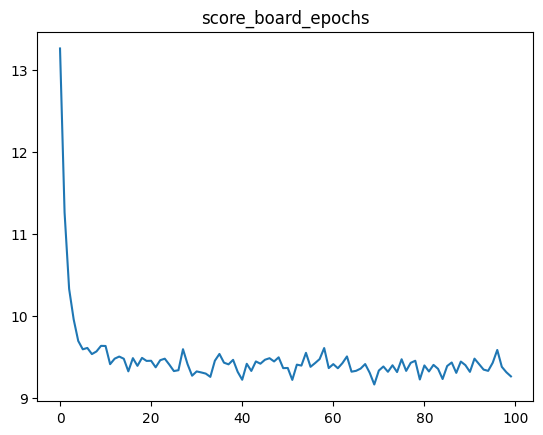

In [79]:
plt.title('score_board_epochs')
plt.plot(np.arange(len(score_board)), score_board)
plt.show()

In [80]:
for i in range(len(model.memory)):
    print(model.memory[0][2])

tensor([1.])
tensor([1.])
tensor([1.])
tensor([1.])
tensor([1.])
tensor([1.])
tensor([1.])
tensor([1.])
tensor([1.])
tensor([1.])
tensor([1.])
tensor([1.])
tensor([1.])
tensor([1.])
tensor([1.])
tensor([1.])
tensor([1.])
tensor([1.])
tensor([1.])
tensor([1.])
tensor([1.])
tensor([1.])
tensor([1.])
tensor([1.])
tensor([1.])
tensor([1.])
tensor([1.])
tensor([1.])
tensor([1.])
tensor([1.])
tensor([1.])
tensor([1.])
tensor([1.])
tensor([1.])
tensor([1.])
tensor([1.])
tensor([1.])
tensor([1.])
tensor([1.])
tensor([1.])
tensor([1.])
tensor([1.])
tensor([1.])
tensor([1.])
tensor([1.])
tensor([1.])
tensor([1.])
tensor([1.])
tensor([1.])
tensor([1.])
tensor([1.])
tensor([1.])
tensor([1.])
tensor([1.])
tensor([1.])
tensor([1.])
tensor([1.])
tensor([1.])
tensor([1.])
tensor([1.])
tensor([1.])
tensor([1.])
tensor([1.])
tensor([1.])
tensor([1.])
tensor([1.])
tensor([1.])
tensor([1.])
tensor([1.])
tensor([1.])
tensor([1.])
tensor([1.])
tensor([1.])
tensor([1.])
tensor([1.])
tensor([1.])
tensor([1.])

In [81]:
# torch.sign(torch.tensor(next_state_psnr - state_psnr)).cuda()
print(next_state_psnr)
print(state_psnr)

9.261957168579102
9.26197624206543


In [82]:
reward

tensor(-1., device='cuda:0')

In [84]:
model.number_of_steps

5000000

In [ ]:
# env = gym.make('CartPole-v1', render_mode="rgb_array")
EPOCHES = 10
target = valid_dataset[0].unsqueeze(0).unsqueeze(0).cuda()
crop_64 = torchvision.transforms.CenterCrop(64)
crop_80 = torchvision.transforms.CenterCrop(80)
target = crop_80(target)
crop_target = crop_64(target)
# randn = torch.rand(1, 3, 80, 80)
# binary_randn = torch.heaviside(randn-0.5, torch.tensor([0.]))
state = binary.detach()
# print(state)
model = NeuralNetwork().cuda()
score_board = []

def find_index(index_1d, shape):
    index_4d = (
        index_1d // (shape[2] * shape[3] * shape[1]),  # 첫 번째 차원
        (index_1d % (shape[2] * shape[3] * shape[1])) // (shape[2] * shape[3]),  # 두 번째 차원
        (index_1d % (shape[2] * shape[3])) // shape[3],  # 세 번째 차원
        index_1d % shape[3]  # 네 번째 차원
    )
    return index_4d


for epoch in range(1, EPOCHES+1):
    
    # score = 0
    for epoch_ in tqdm.tqdm(range(50000)):
        action = model.decision(state).cuda()
        index_4d = find_index(torch.argmax(action), state.shape)
        next_state = state.clone()
        next_state[index_4d] = 1 - next_state[index_4d]
        #기억하고 학습시작.
        state_sim = crop_64(torch.mean(tt.simulate(state, 2e-3).abs()**2, dim=1, keepdim=True))
        next_state_sim = crop_64(torch.mean(tt.simulate(next_state, 2e-3).abs()**2, dim=1, keepdim=True))
        state_psnr = tt.relativeLoss(state_sim, crop_target, tm.get_PSNR)
        next_state_psnr = tt.relativeLoss(next_state_sim, crop_target, tm.get_PSNR)
        reward = torch.sign(torch.tensor(next_state_psnr - state_psnr)).cuda()
        model.memorize(state, torch.tensor(torch.argmax(action).unsqueeze(0)), reward, next_state)
        model.learn()

        state = next_state

        # print(f"epoch :{epoch} score : {reward}")
    score_board.append(state_psnr) #score history에 점수 저장


plt.title('score_board_epochs')
plt.plot(range(1, EPOCHES+1), score_board)
plt.show()

# torch.save(model, f'model.pth')
# print('model_saved')

 71%|███████▏  | 35714/50000 [07:12<02:52, 82.76it/s]

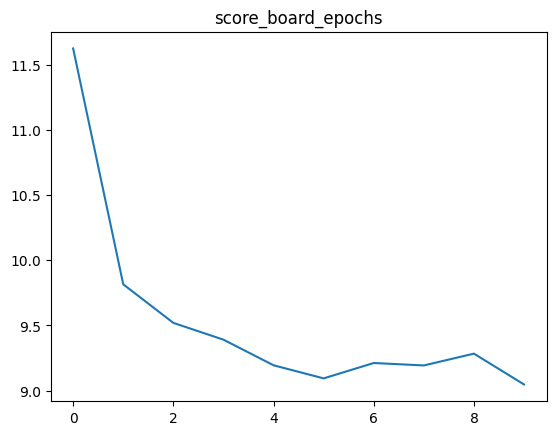

In [103]:
plt.title('score_board_epochs')
plt.plot(np.arange(len(score_board)), score_board)
plt.savefig('reinforce result.png')
plt.show()

In [1]:
state_sim

NameError: name 'state_sim' is not defined

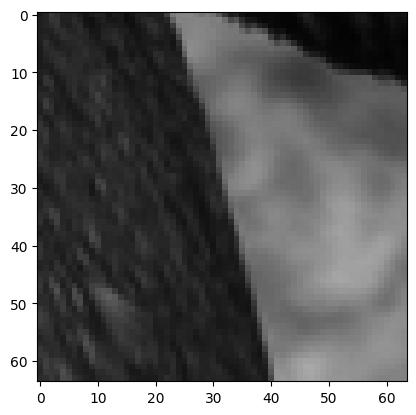

{'wl': 5.15e-07, 'dx': (6.3e-06, 6.3e-06)}

In [22]:
crop_target

In [23]:
index_4d

(tensor(0, device='cuda:0'),
 tensor(2, device='cuda:0'),
 tensor(79, device='cuda:0'),
 tensor(55, device='cuda:0'))

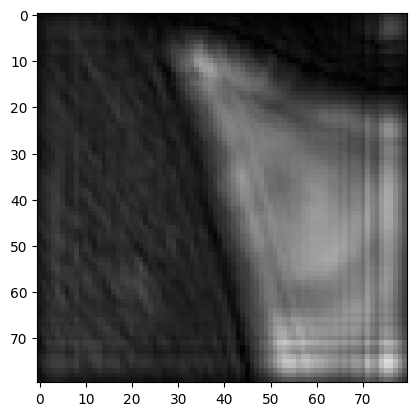

{'wl': 5.15e-07, 'dx': (6.3e-06, 6.3e-06)}

In [24]:
tt.simulate(target, 2e-3)